<a href="https://colab.research.google.com/github/aminrigi/Network_CommunityDetection/blob/master/DS_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To add:

* Permutation Importance (https://scikit-learn.org/stable/modules/permutation_importance.html )

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from google.colab import drive # importing data from my google drive to colab

In [ ]:
drive.mount('/content/gdrive')
# reading from google drive
df = pd.read_csv("/content/gdrive/My Drive/aminFiles/classification_task_train.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Exploratory Data Analysis

In [ ]:
df.head(5)

,id,ae,wc,fn,oc,ed,en,rd,cg,cl,hw,nc,se,y
0,1,62,wc004,199265.0,oc003,ed005,11,1,0,0,40,nc001,se002,False
1,2,29,wc003,88781.0,oc001,ed003,13,4,0,0,50,nc001,se001,False
2,3,36,wc001,202071.0,oc001,ed003,13,3,0,0,45,nc001,se002,True
3,4,31,wc004,199735.0,oc006,ed016,1,2,0,0,24,nc001,se001,False
4,5,59,wc002,185764.0,oc001,ed003,13,5,99999,0,43,nc001,se001,True


In [ ]:
print('Total rows:', df.shape[0])
df.describe()

Total rows: 29304


,id,ae,fn,en,rd,cg,cl,hw
count,29304.000000,29304.000000,2.921500e+04,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000
mean,14652.500000,38.588179,1.898685e+05,10.077293,3.015049,1101.668100,88.055010,40.416052
std,8459.480481,13.646619,1.057904e+05,2.580710,1.409311,7502.606259,404.360572,12.349827
min,1.000000,17.000000,1.376900e+04,1.000000,1.000000,0.000000,0.000000,1.000000
25%,7326.750000,28.000000,1.177890e+05,9.000000,2.000000,0.000000,0.000000,40.000000
50%,14652.500000,37.000000,1.786860e+05,10.000000,3.000000,0.000000,0.000000,40.000000
75%,21978.250000,48.000000,2.376705e+05,12.000000,4.000000,0.000000,0.000000,45.000000
max,29304.000000,90.000000,1.484705e+06,16.000000,5.000000,99999.000000,4356.000000,99.000000


In [ ]:
df.dtypes

id      int64
ae      int64
wc     object
fn    float64
oc     object
ed     object
en      int64
rd      int64
cg      int64
cl      int64
hw      int64
nc     object
se     object
y        bool
dtype: object

Five variables seem to be categorical.

First, let's have a look at the numerical variables:


In [ ]:
df['y'] = df['y'].astype(int)# converting bool to int
df = df.drop('id',1) # droping id col

Let's take a look at the histogram of the variables:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34ff39e6d8>,
      dtype=object)

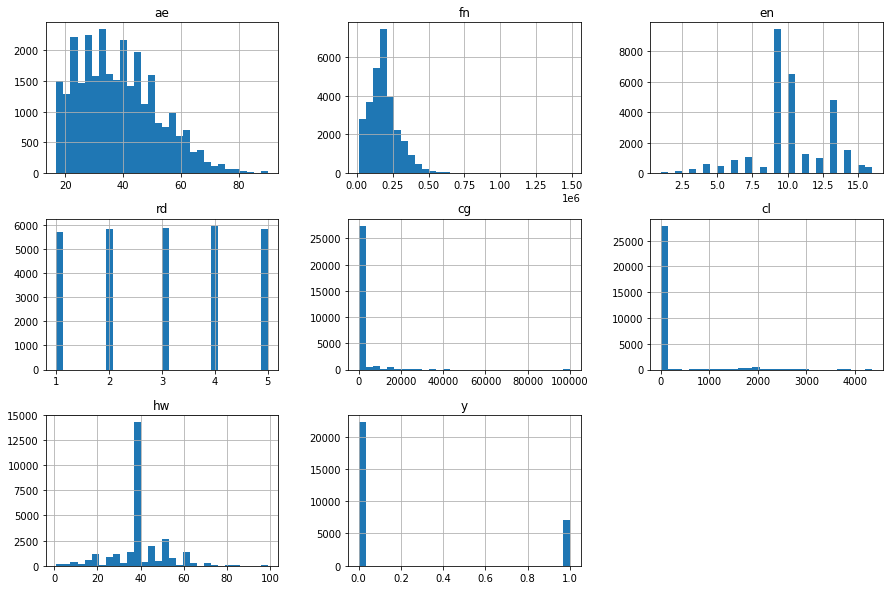

In [ ]:
df.hist(bins=30, figsize=(15, 10))

Some variables such as cg and d are highly biased. Same goes for hw. y is imbalanced as well.



Let's have a look at the correlation matrix:

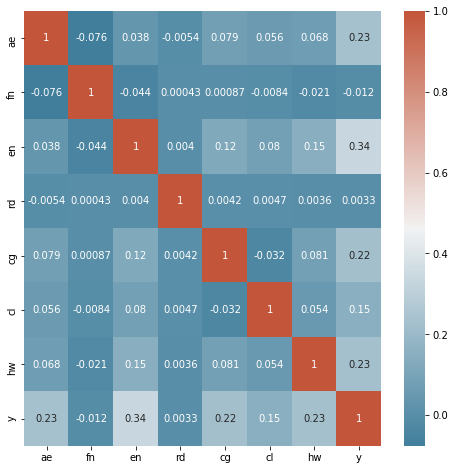

In [ ]:
numbers = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = df.select_dtypes(include=numbers) #extracting numerical features

corr = numerics.corr() #correlation matrix

mask = np.triu(np.ones_like(corr, dtype=bool))# Generate a mask for the upper triangle

f, ax = plt.subplots(figsize=(8, 8))# figure size

cmap = sns.diverging_palette(230, 20, as_cmap=True) # nicer colours

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap = cmap)



Pairwise correlation doesn't seem to be significant.

Categorical ones:

In [ ]:
cat_vars = df.select_dtypes(include=['object']).copy() #extracting categorical variables
cat_vars.columns # seeing the cat vars

Index([], dtype='object')

Let's dig deeper

unique values in wc: 8


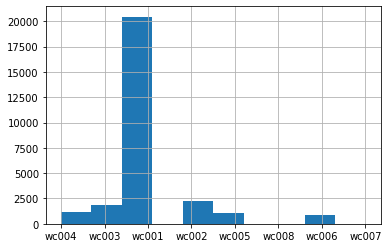

In [ ]:
print('unique values in wc:',df['wc'].nunique())
df['wc'].hist()

unique values in oc: 14


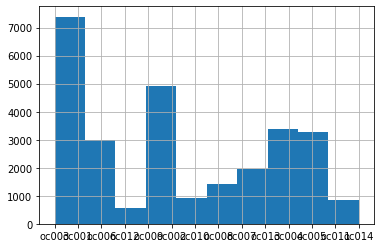

In [ ]:
print('unique values in oc:',df['oc'].nunique())
df['oc'].hist()

unique values in ed: 16


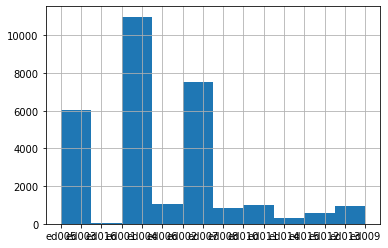

In [ ]:
print('unique values in ed:',df['ed'].nunique())
df['ed'].hist()

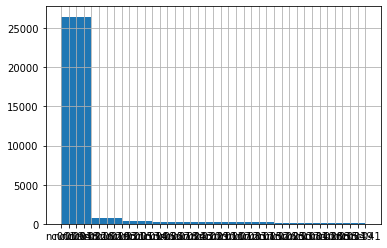

In [ ]:
df['nc'].hist()

*As a part of exporatory data analysis, I usually plot numerical vars grouped by categorical vars. For example, age by gender. I skip it since it doesn't seem to be very meaningful with anonymised columns.*

# Missing values

In [ ]:
df.isnull().values.any() # are there NAs?

True

Bummer! let's investigate more:

In [ ]:
na_rows_count = np.count_nonzero(df.isnull()) # count of rows that have NAs in them
print('Count of rows with NAs:', na_rows_count)
print('percentage of rows with NAs:', na_rows_count/df.shape[0] * 100 )

Count of rows with NAs: 3936
percentage of rows with NAs: 13.431613431613432


The number of rows with NAs is too big to be ignored (or dropped).

My usual approach: why these NAs occur? Is there a story behind them? (e.g. a sensor problem which happens to particular patterns/rows) Are they randomly distributed?

A couple of approaches:

*   Drop NAs (cols or rows)
*   Imputation:
    *    k-Nearest Neighbor
    *    Mode for categoricals, mean for numerics,...
*   Assuming NAs are just another value (or category) in categorical variables (only for categorical variables).

Here, I go with imputation. We can have multiple iterations using other approaches and compare the results.





In [ ]:
 df.apply(lambda x: sum(x.isnull()),axis=0) # getting the count of NAs

In [ ]:
df.isnull().sum()/len(df)*100 #summary of NAs: getting NAs percentage

ae    0.000000
wc    5.640868
fn    0.303713
oc    5.661343
ed    0.000000
en    0.000000
rd    0.000000
cg    0.000000
cl    0.000000
hw    0.000000
nc    1.825689
se    0.000000
y     0.000000
dtype: float64

There's a small percentage of NAs in fn (numerical) and considerable percentage of NAs in wc and oc (both catergorical). There are some missing data in nc as well.

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder


df_copy = df.copy()

#applying label encoder so the distance is meaningful
df = df.apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

imputer = KNNImputer(n_neighbors=1) # because of categorical
df = pd.DataFrame(imputer.fit_transform(df))
df.columns=df_copy.columns
df.index=df_copy.index

df.isnull().values.any() # are there NAs?

False

# Encoding variables

### Encoding categorical variables using one-hot encoder:

When we encode categorical variables, we need to make sure all categories are captured. By that I mean if a value for a category appears in the test data while it doesn't exist in the training, we need add a column in the training in which all the observations are set to zero. Same goes for test. In the next step I address this issue with the gurantee that *no leakage from train to test (or vice versa) is happenning*.

Let's have a look at the categories at the test data:

In [ ]:
#drive.mount('/content/gdrive')
# reading from google drive
df_test = pd.read_csv("/content/gdrive/My Drive/aminFiles/classification_task_test.csv")

In [ ]:
print('unique values in wc in test:',df_test['wc'].nunique())

unique values in wc in test: 7


My guess was right, category values in test and train don't 100% match. In the next steps, we impute NAs in test set, row-bind the two datasets, apply one-hot-encoder, and finally separate the two datasets.

In [ ]:
df_test.isnull().values.any() # are there NAs?

True

In [ ]:
df_test_copy = df_test.copy()

df_test = df_test.apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

imputer = KNNImputer(n_neighbors=1)
df_test = pd.DataFrame(imputer.fit_transform(df_test))
df_test.columns=df_test_copy.columns
df_test.index=df_test_copy.index

df_test.isnull().values.any() # are there NAs?

False

In [ ]:
df_test['y'] = 0 # adding a dummy column for the purpose of row-binding, we'll remove it afterwards.
df_test = df_test.drop('id',1) # droping the id col

#concating
df_total = pd.concat([df, df_test])

#one-hot-encoding
df_total = pd.get_dummies(df_total, columns=cat_vars.columns, prefix=cat_vars.columns)

#separating
df = df_total[:df.shape[0]]
df_test = df_total[df.shape[0]:]



 ### Scaling

Now that everything is encoded, it's time to **scale** variables. One thing that we need to be careful is that *rd* is a catogrical variable. Since it has numerical values, I assume it's an ordinal categorical variable (usually a domain expert can decide this). As a result, I use MinMax Scaler for *rd* and sandard scaler for other features.

In [ ]:
#Scaling training

rd_scaled = (  df['rd'] - min(df['rd'])  ) / ( max(df['rd']) - min(df['rd']) ) #MinMax scaling

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
df = pd.DataFrame( standard_scaler.fit_transform(df) )

df.columns=df_copy.columns
df.index=df_copy.index
df['rd'] = rd_scaled


#Scaling test

rd_scaled_t = (  df_test['rd'] - min(df_test['rd'])  ) / ( max(df_test['rd']) - min(df_test['rd']) ) #MinMax scaling

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
df_test = pd.DataFrame( standard_scaler.fit_transform(df_test) )

df_test.columns=df_copy.columns
df_test['rd'] = rd_scaled_t


In [ ]:
#dropping the dummy y from the test
df_test = df_test.drop('y',1)


#saving the pre-processed dataframes
df.to_pickle('/content/gdrive/My Drive/aminFiles/train.pkl')
df_test.to_pickle('/content/gdrive/My Drive/aminFiles/test.pkl')

Both pre-processed train and test datasets are saved. Now, I focus on the training set.

In [ ]:
drive.mount('/content/gdrive')
df = pd.read_pickle('/content/gdrive/My Drive/aminFiles/train.pkl')
df_test = pd.read_pickle('/content/gdrive/My Drive/aminFiles/test.pkl')
df_copy = df.copy()

Mounted at /content/gdrive


Since we have a separate test set, we break it into train and validation sets. (note: our sampling is not stratified atm)

In [ ]:
y = df['y']
y = y.astype('int')
X = df.drop('y',1)


from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

Now that the data is split into train and validation, I start with logistic regression:

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

from sklearn.metrics import accuracy_score
print('Logistic Regression Accuracy: ', accuracy_score(y_val, y_pred))

Logistic Regression Accuracy:  0.8336063336063336


Accuracy seem to be good. Let's dig a bit deeper:

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))


[[5269  315]
 [ 904  838]]
Precision: 0.7267996530789246
Recall: 0.48105625717566014
F1: 0.5789291882556131


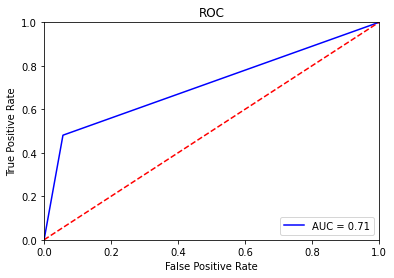

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As expected (from looking at the labels in EDA) the accuracy is good because the data is imbalanced. The confusion matrix confirms it. Recall is not good, asn as a result F1. The ROC cureve tells us that the classifier is bettar than random (no classifer), but not that good either. Before k-fold X validation or using more advanced models, or tuning, we need to tackle the imbalanced nature of the data. Let's have a look at the label count:

In [ ]:
# wrapping evaluations in a function for ease of use
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
def evaluate_model(y_val, y_pred):
  print(confusion_matrix(y_val, y_pred))
  print('Precision:', precision_score(y_val, y_pred))
  print('Recall:', recall_score(y_val, y_pred))
  print('F1:', f1_score(y_val, y_pred))
  print('Accuracy: ', accuracy_score(y_val, y_pred))
  print('Mean abs error: ', mean_absolute_error(y_val, y_pred))
  fpr, tpr, threshold = roc_curve(y_val, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.title('ROC')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


In [ ]:
y.value_counts() # getting the count of values in pandas

0    22247
1     7057
Name: y, dtype: int64

# Adressing the imbanced data

A few approach to fix imbalanced problem:
* Random under-sampling: reducing observations from the majority label
* Random over-sampling: adding more copies from the minority label
* Synthetic Minority Oversampling Technique (SMOTE): Creates synthetic points from the minority. (chooses random points in the knn of minority points)


Let's start with **under-sampling**:


We split data in to train and validation sets. Sampling approaches are applied on the test only and are validated using validation set.

[[3507  940]
 [ 346 1068]]
Precision: 0.5318725099601593
Recall: 0.7553041018387553
F1: 0.624196376388077
Accuracy:  0.7805835181709606
Mean abs error:  0.21941648182903942


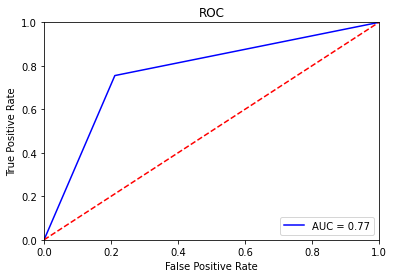

In [ ]:
#splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)

from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

under_sampler = RandomUnderSampler()
X_rus_train, y_rus_train = under_sampler.fit_resample(X_train, y_train)

model = LogisticRegression()
model.fit(X_rus_train, y_rus_train)
y_rus_pred = model.predict(X_val)


evaluate_model(y_val, y_rus_pred) #evaluating

As we can see recall and F1 have improved considerably better. Now let's use **over-sampling**:

[[4420 1164]
 [ 425 1317]]
Precision: 0.5308343409915357
Recall: 0.7560275545350172
F1: 0.6237272081458679
Accuracy:  0.7831012831012831
Mean abs error:  0.2168987168987169


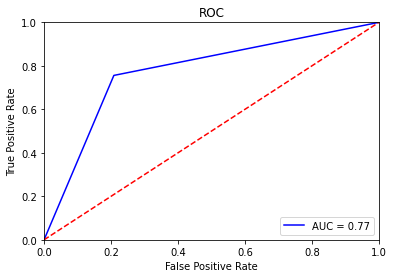

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler()
X_ros_train, y_ros_train = over_sampler.fit_resample(X_train, y_train)

model = LogisticRegression()
model.fit(X_ros_train, y_ros_train)
y_ros_pred = model.predict(X_val)

evaluate_model(y_val, y_ros_pred)

The metrics are quite similar. Now **SMOTE**:

[[3502  945]
 [ 345 1069]]
Precision: 0.5307845084409136
Recall: 0.756011315417256
F1: 0.6236872812135356
Accuracy:  0.7799010407780242
Mean abs error:  0.22009895922197578


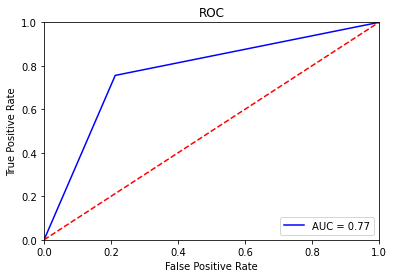

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)

model = LogisticRegression()
model.fit(X_smote_train, y_smote_train)
y_smote_pred = model.predict(X_val)

evaluate_model(y_val, y_smote_pred)

The results are quite similar for all three approaches.

# Buliding models

The results are quite similar to under-sampling but worse than oversampling. (To use over-sampling with k-fold we need to make sure not to k-fold after oversampling -- causes leakage). For now, I go with simple random over sampling split and will use different algorithms/models.

**SVM**

[[3522  925]
 [ 352 1062]]
Precision: 0.5344740815299447
Recall: 0.751060820367751
F1: 0.6245221993531314
Accuracy:  0.7821190923050674
Mean abs error:  0.2178809076949326


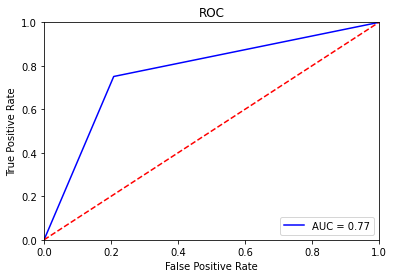

In [ ]:
from sklearn import svm
model = svm.SVC(kernel='linear')
model.fit(X_ros_train, y_ros_train)
y_ros_pred = model.predict(X_val)

evaluate_model(y_val, y_ros_pred)

SVM's results are slightly better than logistic regression. Let's try RBF (Radial Basis Function) kernel as well

[[3537  910]
 [ 354 1060]]
Precision: 0.5380710659898477
Recall: 0.7496463932107497
F1: 0.6264775413711583
Accuracy:  0.7843371438321105
Mean abs error:  0.21566285616788944


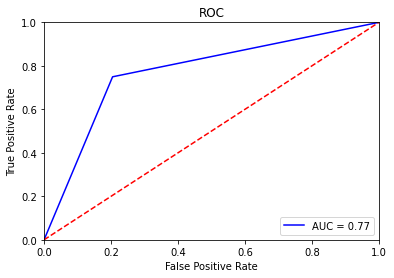

In [ ]:
model = svm.SVC(kernel='rbf')
model.fit(X_ros_train, y_ros_train)
y_ros_pred = model.predict(X_val)
evaluate_model(y_val, y_ros_pred)

Random Forest:

[[3993  454]
 [ 555  859]]
Precision: 0.6542269611576542
Recall: 0.6074964639321075
F1: 0.62999633296663
Accuracy:  0.8278450776318035
Mean abs error:  0.17215492236819654


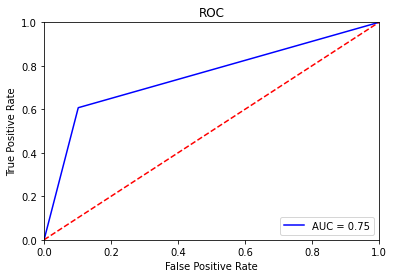

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_ros_train, y_ros_train)
y_ros_pred = model.predict(X_val)

evaluate_model(y_val, y_ros_pred)

Compared to SVM and LR, Random forest improves most of the metrics (except for recall and auc). Let's give xGboost a try as well:

[[3587  860]
 [ 300 1114]]
Precision: 0.5643363728470111
Recall: 0.7878359264497878
F1: 0.6576151121605668
Accuracy:  0.8020815560484559
Mean abs error:  0.1979184439515441


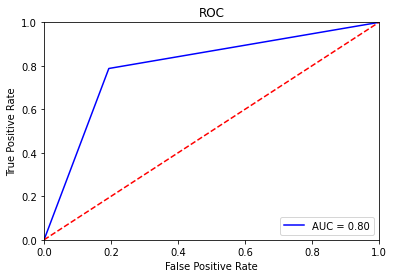

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()

X_ros_train = pd.DataFrame(X_ros_train)
X_ros_train.columns = X_train.columns

model.fit(X_ros_train, y_ros_train)
y_ros_pred = model.predict(X_val)
evaluate_model(y_val, y_ros_pred)

As we can see XGBoost beats SVM and LR in all metrics. XGBoost and RF are comparable(in some metrics XGB outperforms RF, in the rest RF outperforms). If we set F1 as our most important metric, XGB is the best so far. Let's see how catBoost performs:

[[3744  703]
 [ 325 1089]]
Precision: 0.6077008928571429
Recall: 0.7701555869872702
F1: 0.6793512164691204
Accuracy:  0.8246033100153557
Mean abs error:  0.17539668998464425


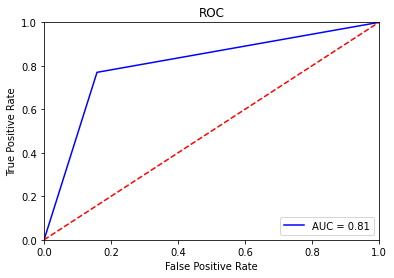

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(logging_level='Silent')
model.fit(X_ros_train, y_ros_train)
y_ros_pred = model.predict(X_val)
evaluate_model(y_val, y_ros_pred)

catBoost outperforms all other models. I must add that each of the tried models has its own parameters. In order to select a model, we can tune their input parameters. Here, I just went with default parameters. Based on default parameters, among the tried models, we have a winner: catBoost.

### Stratified k-fold random over-sampling

In order to choose the best model, it's better to use all of training set (here X_train). k-fold cross validation ensures this. However, we have an imbalanced dataset. In such cases, we can use stratified k-fold cross validation. That means in each step of the k-fold cross valdiation, a sampling (here over-sampling) is performed.

According to Andrew Ng [1], when we want to select a model, it's best to focus on the most important metric. Otherwise, we end up with a multi-objective optimisation problem. To choose the best model, we can perform k-fold cross validation for all model and select the best one. For demonstration, I try stratified 10-fold cross validation for a couple of models and set F1 and the performance metric.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline


# define pipeline
steps = [('over', RandomOverSampler()), ('model', CatBoostClassifier(logging_level='Silent'))]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score:', score)

F1 Score: 0.8166805079591312


In [ ]:
# define pipeline
steps = [('over', RandomOverSampler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score:', score)

F1 Score: 0.7783581843919439


### Model Parameters Tunning

catBoost has two important parameters: *learning_rate* and *l2_leaf_reg* (learning rate and leaf regularisation term). I optimise the model using *hyperopt* package. The goal is to find the best model parameters that maximise F1.

In [ ]:
import hyperopt
from catboost import CatBoostClassifier

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric='F1',
        verbose=False,
        loss_function='Logloss'
    )

    model.fit(X_ros_train, y_ros_train)
    y_ros_pred = model.predict(X_val)

    return 1 - f1_score(y_val, y_ros_pred) # as hyperopt minimises

In [ ]:
from numpy.random import RandomState

# these param ranges are recommended by catBoost help
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials
)

print(best)

100%|██████████| 50/50 [07:54<00:00,  9.48s/it, best loss: 0.31604226705091265]
{'l2_leaf_reg': 1.0, 'learning_rate': 0.11853557179959676}


Now that we have the opimal parameters, we build a model with the optimal paramters and test on the validation set:

[[3806  641]
 [ 346 1068]]
Precision: 0.6249268578115857
Recall: 0.7553041018387553
F1: 0.6839577329490873
Accuracy:  0.8315987032929534
Mean abs error:  0.16840129670704657


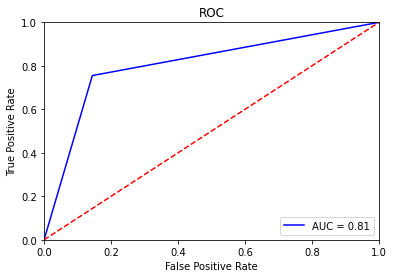

In [ ]:
model = CatBoostClassifier(
        l2_leaf_reg=int(best['l2_leaf_reg']),
        learning_rate= best['learning_rate'],
        iterations=500,
        eval_metric='F1',
        verbose=False,
        loss_function='Logloss'
)
model.fit(X_ros_train, y_ros_train)
y_ros_pred = model.predict(X_val)
evaluate_model(y_val, y_ros_pred)

After paramater tunning all metrics (except recall) are improved.

## Building the final model

Moment of truth! Now that we have a model with good parameters, it's time to build a model based on the entirity of traning data.

First step, random over sampling:

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler()
X_ros, y_ros = over_sampler.fit_resample(X, y)

Second step, train the model with optimal parameters using all of training data (ofc, using random over sampler)

In [ ]:
model = CatBoostClassifier(
        l2_leaf_reg=int(best['l2_leaf_reg']),
        learning_rate= best['learning_rate'],
        iterations=500,
        eval_metric='F1',
        verbose=False,
        loss_function='Logloss'
)
model.fit(X_ros, y_ros)

Final step, predicting the test result:

In [ ]:
y_test = model.predict(df_test)

#attaching the results to the test set and exporting it
df_test_csv = pd.read_csv("/content/gdrive/My Drive/aminFiles/classification_task_test.csv")
df_test_csv['y'] = y_test.astype('bool')
df_test_csv.to_csv("/content/gdrive/My Drive/aminFiles/classification_task_test_answer.csv")

# Summary and Conclusion

The steps that I've taken can be summarised as follow
* Exploratory data analysis: looking and the distrbution of features, investigating numerical and categorical variables.
* Addressing missing values usin k-NN impute
* Scaling and feature transformation
* Adressing imbalanced nature of the dataset
* Bulding, analysing, and tunning models

In my view an important key to the whole process is **iteration**. We need to iterate several times and choose the best approaches and parameters.





# Appendix

Below is some of the things that I did for this task which I like to include them as apendix. Some of them provide extra information and some other are aras for further investigations.

## Learning Curves (bias-variance trade-off)
Learning curves are good to analyse bias-variance trade-off. Based on them we can decide, if we should add/remove features, add/remove samples, or use more complex models or not. Here I use a code from scikit (https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) to plot learning curves for logistic regression and SVM.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    return plt


fig, axes = plt.subplots(1, 2, figsize=(10, 5))


title = "Logistic Regression"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

model = LogisticRegression()

plot_learning_curve(model, title, X, y, cv=cv, n_jobs=1)

title = r"SVM"


cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

from sklearn import svm
estimator = svm.SVC(kernel='linear')
plot_learning_curve(estimator, title, X, y,
                    cv=cv, n_jobs=1)

plt.show()

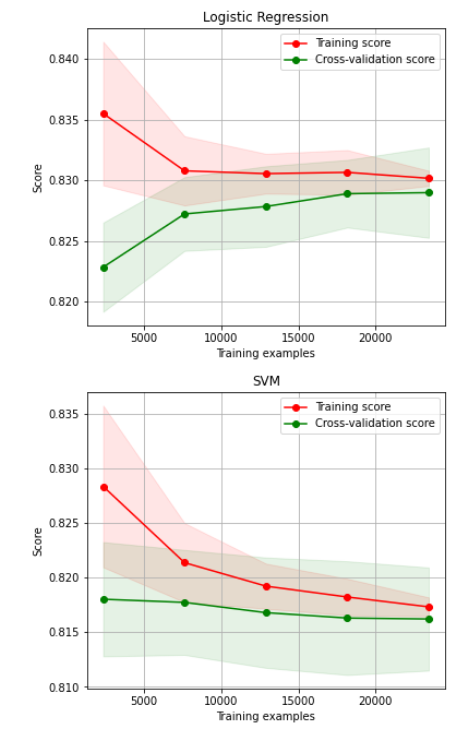

This code above performs ordinary random sampling and it's obvious there's a high bias. This is expected because of the imbalanced data. The code needs to be modified: sampling must change into random over-sampling. Unfortunately, there's not enough time to make these changes now. Anyway, a part of analysis is to plot learning curves for different models and features and analyse bias-variance trade-off.

## More features engineering

From EDA we remember that a couple of features were highly skewed.

In [ ]:
X.skew(axis = 0, skipna = True)[0:7]

ae    0.560728
fn    0.058533
en   -0.315526
rd   -0.016200
cg    3.546970
cl    5.254992
hw    0.066615
dtype: float64

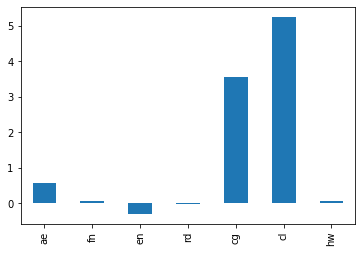

In [ ]:
X.skew(axis = 0, skipna = True)[0:7].plot.bar()

cg and cl are highly skewed.

#### Data transformation:
Let's try a few transformations (log, cube root, and sinh) on the highly skewed variables and see if it decreases skewness:

log transformation:

In [ ]:
from scipy.stats import skew

log_cg = np.log(X['cg']-min(X['cg'])+1)
std_log_cg = (log_cg - np.mean(log_cg)) / np.std(log_cg)
print('std_log skew cg:', skew(log_cg))
print('Sinh skew cg', skew(np.sinh(X['cg'])))
cube_cg = np.cbrt(X['cg'])
print('cube skew:', skew(cube_cg))

log_cl = np.log(X['cl']-min(X['cl'])+1)
std_log_cl = (log_cl - np.mean(log_cl)) / np.std(log_cl)
print('std_log skew cl:', skew(log_cl))
cube_cl = np.cbrt(X['cl'])
print('cube skew cl:', skew(cube_cl))



std_log skew cg: 3.272027615588268
Sinh skew cg 5.354892915783103
cube skew: 3.1124200349164592
std_log skew cl: 4.596921343290603
cube skew cl: 4.382172365648493


Seems log transformation doesn't decrease the skewness that much. Same story goes for sinh and cubic root. One approach is to remove **outliers** and performing transformation afterwards (I tried this one, wasn't helpful). Analysing outliers requires SME knowledge. Another approach is binning the skewed varibles into a number of bins.

In [ ]:
X_t = X.copy() # t for transformed

In [ ]:
X_t.columns[:7]

Index(['ae', 'fn', 'en', 'rd', 'cg', 'cl', 'hw'], dtype='object')

In [ ]:
#X_t['ae_fn'] = X_t['ae']*X_t['fn']
#X_t['en_cg'] = X_t['en']*X_t['cg']
#X_t['en_cl'] = X_t['en']*X_t['cl']
X_t['cl_3'] = np.cbrt(X_t['cl'])
X_t['cg_3'] = np.cbrt(X_t['cg'])
X_t['fn_2'] = np.cbrt(X_t['fn'])


In [ ]:
#splitting
X_t_train, X_t_val, y_t_train, y_t_val = train_test_split(X_t, y, test_size=0.25, random_state=1)

#random over-sampling
over_sampler = RandomOverSampler()
X_t_ros_train, y_t_ros_train = over_sampler.fit_resample(X_t_train, y_t_train)

[[4448 1136]
 [ 426 1316]]
Precision: 0.5367047308319739
Recall: 0.7554535017221584
F1: 0.6275631855030996
Accuracy:  0.7867867867867868
Mean abs error:  0.2132132132132132


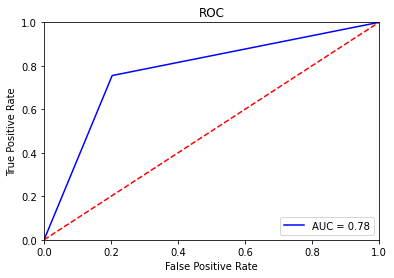

In [ ]:
model = LogisticRegression()
model.fit(X_t_ros_train, y_t_ros_train)
y_t_ros_pred = model.predict(X_t_val)

evaluate_model(y_t_val.astype('int'), y_t_ros_pred.astype('int'))

[[4680  904]
 [ 404 1338]]
Precision: 0.5967885816235504
Recall: 0.7680826636050516
F1: 0.6716867469879517
Accuracy:  0.8214578214578214
Mean abs error:  0.17854217854217855


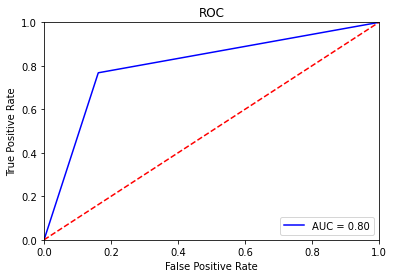

In [ ]:
model = CatBoostClassifier(logging_level='Silent')
model.fit(X_t_ros_train, y_t_ros_train)
y_t_ros_pred = model.predict(X_t_val)

evaluate_model(y_t_val.astype('int'), y_t_ros_pred.astype('int'))

As expected transformation (here cube root) doesn't make much difference. In a few iterations, I also created a couple new features by multiplying other features. No impact on the outcome.

In [ ]:
X_t = X.copy() # t for transformed
X_t['y'] = y

X_t = X_t[X_t['cg'] < X_t['cg'].quantile(.95)]
X_t = X_t[X_t['cl']< X_t['cl'].quantile(.97)]



In [ ]:
log_cg = np.log(X_t['cg']-min(X_t['cg'])+1)
std_log_cg = (log_cg - np.mean(log_cg)) / np.std(log_cg)
print('std_log skew cg:', skew(log_cg))
print('Sinh skew cg', skew(np.sinh(X_t['cg'])))
cube_cg = np.cbrt(X_t['cg'])
print('cube skew:', skew(cube_cg))

log_cl = np.log(X_t['cl']-min(X_t['cl'])+1)
std_log_cl = (log_cl - np.mean(log_cl)) / np.std(log_cl)
print('std_log skew cl:', skew(log_cl))
cube_cl = np.cbrt(X_t['cl'])
print('cube skew cl:', skew(cube_cl))

std_log skew cg: 5.546617889023087
Sinh skew cg 7.306094245968596
cube skew: 5.247990084085938
std_log skew cl: 7.428289829440748
cube skew cl: 7.023741179538631


The results indicate the approach is not effective.

#### Binary classification using keras


This is just the frist try to use keras for this problem.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers


# input shape
input_shape = (X_ros_train.shape[1],)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(layers.Dense(50, input_shape=input_shape, activation='relu'))
model.add(layers.Dense(50, activation='sigmoid'))
model.add(layers.Dense(1))
model.summary()



from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Configure the model and start training
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(X_ros_train, y_ros_train, validation_split=0.25, epochs=10, verbose=0)

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_val, y_val, verbose=0)

print('Precision:', precision)
print('Recall:', recall)
print('f1', f1_score)
print('Accuracy', accuracy)

Feature shape: (88,)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 50)                4450      
_________________________________________________________________
dense_52 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 51        
Total params: 7,051
Trainable params: 7,051
Non-trainable params: 0
_________________________________________________________________
Precision: 0.6132016777992249
Recall: 0.6429523229598999
f1 0.6106857657432556
Accuracy 0.8136836886405945
